# Refactor of CWT transfrom

Based on: https://github.com/tomrunia/PyTorchWavelets

In [1]:
import numpy as np
import pandas as pd
import pywt
import math
import torch
import torch.nn as nn
from scipy import signal
from scipy import optimize
from scipy.misc import derivative
from scipy.special import factorial, gamma, hermitenorm
import scipy.fftpack as fft
import matplotlib.pyplot as plt
from pathlib import Path
from timm.models.layers.conv2d_same import conv2d_same

COMP_NAME = "g2net-gravitational-wave-detection"

INPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_data/{COMP_NAME}/")
OUTPUT_PATH = Path(f"/mnt/storage_dimm2/kaggle_output/{COMP_NAME}/")

# SciPy CWT

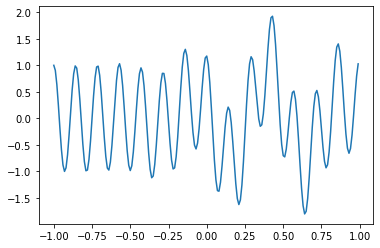

In [2]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

plt.plot(t, sig);

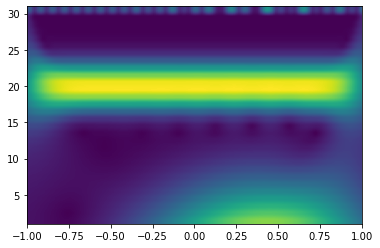

In [3]:
widths = np.arange(1, 31)

cwtmatr = signal.cwt(sig, signal.morlet2, widths)
magn = np.absolute(cwtmatr)

plt.imshow(
    magn,
    extent=[-1, 1, 1, 31],
#     cmap="PRGn",
    aspect="auto",
    vmax=magn.max(),
    vmin=magn.min(),
);

# Utils

In [4]:
def load_file(id_, folder="train"):
    path = INPUT_PATH / folder / id_[0] / id_[1] / id_[2] / f"{id_}.npy"
    waves = np.load(path)
    # return waves / np.max(waves, axis=1).reshape(3, 1)
    return waves / np.max(waves)


# https://www.kaggle.com/kevinmcisaac/g2net-spectral-whitening
def apply_whiten(signal, window=False):  # signal is a numpy array
    
    signal = torch.from_numpy(signal).float()
    
    if signal.ndim == 2:
        win_length = signal.shape[1]
    else:
        win_length = signal.shape[0]
    
    # Not needed if a window has already been applied. Tukey is probably better
    if window:    
        hann = torch.hann_window(win_length, periodic=True, dtype=float)
        signal *= hann
        
    spec = fft(signal)
    mag = torch.sqrt(torch.real(spec * torch.conj(spec)))
    return torch.real(ifft(spec / mag)).numpy() * np.sqrt(win_length / 2)


# Cell 33 of https://www.gw-openscience.org/LVT151012data/LOSC_Event_tutorial_LVT151012.html
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def apply_bandpass(x, lf=25, hf=500, order=4, sr=2048):
#     sos = signal.butter(order, [lf * 2.0 / sr, hf * 2.0 / sr], btype="bandpass", output="sos")
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    return signal.sosfiltfilt(sos, x) / normalization

In [5]:
# wave_id = "098a464da9"  # Super clean signal
wave_id = "000a5b6e5c"
# wave_id = "00000e74ad"
# wave_id = "00001f4945"  # target = 0
# wave_id = "0000661522"  # target = 0
# wave_id = "0000a38978"

In [6]:
x = load_file(wave_id)
x *= signal.tukey(4096, 0.2)
x = apply_bandpass(x, 35, 350)
x.shape

(3, 4096)

In [7]:
x_ten = torch.tensor(x, dtype=torch.float32).view(1, 3, 4096)

# Implementation

In [8]:
# https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py

class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s

In [99]:
import numpy as np
import torch
import torch.nn as nn
from scipy import optimize

# https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py
class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s
    
    
    
class Paul(object):
    def __init__(self, m=4):
        """Initialise a Paul wavelet function of order `m`."""
        self.m = m

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0):
        """
        Complex Paul wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If `s` is not specified, i.e. set to 1, this can be
            used as the non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Paul wavelet at the given time
        The Paul wavelet is defined (in time) as::
            (2 ** m * i ** m * m!) / (pi * (2 * m)!) \
                    * (1 - i * t / s) ** -(m + 1)
        """
        m = self.m
        x = t / s

        const = (2 ** m * 1j ** m * factorial(m)) / (np.pi * factorial(2 * m)) ** 0.5
        functional_form = (1 - 1j * x) ** -(m + 1)

        output = const * functional_form

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Paul"""
        return 4 * np.pi * s / (2 * self.m + 1)

    def scale_from_period(self, period):
        raise NotImplementedError()

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Paul.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Paul wavelet at the given frequency
        """
        m = self.m
        x = w * s
        # Heaviside mock
        Hw = 0.5 * (np.sign(x) + 1)

        # prefactor
        const = 2 ** m / (m * factorial(2 * m - 1)) ** 0.5

        functional_form = Hw * (x) ** m * np.exp(-x)

        output = const * functional_form

        return output

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return s / 2 ** 0.5


class DOG(object):
    def __init__(self, m=2):
        """Initialise a Derivative of Gaussian wavelet of order `m`."""
        if m == 2:
            # value of C_d from TC98
            self.C_d = 3.541
        elif m == 6:
            self.C_d = 1.966
        else:
            pass
        self.m = m

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0):
        """
        Return a Derivative of Gaussian wavelet,
        When m = 2, this is also known as the "Mexican hat", "Marr"
        or "Ricker" wavelet.
        It models the function::
            ``A d^m/dx^m exp(-x^2 / 2)``,
        where ``A = (-1)^(m+1) / (gamma(m + 1/2))^.5``
        and   ``x = t / s``.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        Parameters
        ----------
        t : float
            Time. If `s` is not specified, this can be used as the
            non-dimensional time t/s.
        s : scalar
            Width parameter of the wavelet.
        Returns
        -------
        out : float
            Value of the DOG wavelet at the given time
        Notes
        -----
        The derivative of the Gaussian has a polynomial representation:
        from http://en.wikipedia.org/wiki/Gaussian_function:
        "Mathematically, the derivatives of the Gaussian function can be
        represented using Hermite functions. The n-th derivative of the
        Gaussian is the Gaussian function itself multiplied by the n-th
        Hermite polynomial, up to scale."
        http://en.wikipedia.org/wiki/Hermite_polynomial
        Here, we want the 'probabilists' Hermite polynomial (He_n),
        which is computed by scipy.special.hermitenorm
        """
        x = t / s
        m = self.m

        # compute the Hermite polynomial (used to evaluate the
        # derivative of a Gaussian)
        He_n = hermitenorm(m)
        # gamma = scipy.special.gamma

        const = (-1) ** (m + 1) / gamma(m + 0.5) ** 0.5
        function = He_n(x) * np.exp(-(x ** 2) / 2) * np.exp(-1j * x)

        return const * function

    def fourier_period(self, s):
        """Equivalent Fourier period of derivative of Gaussian"""
        return 2 * np.pi * s / (self.m + 0.5) ** 0.5

    def scale_from_period(self, period):
        raise NotImplementedError()

    def frequency(self, w, s=1.0):
        """Frequency representation of derivative of Gaussian.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the derivative of Gaussian wavelet at the
            given time
        """
        m = self.m
        x = s * w
        # gamma = scipy.special.gamma
        const = -(1j ** m) / gamma(m + 0.5) ** 0.5
        function = x ** m * np.exp(-(x ** 2) / 2)
        return const * function

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s


class CWT(nn.Module):
    def __init__(
        self,
        dj=0.0625,
        dt=1 / 2048,
        fmin: int = 20,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
        stride: int = 1,
        wavelet = Morlet()
    ):
        super().__init__()
        self.wavelet = wavelet

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, stride)  # Strides > 1 not yet supported with same padding
        self.padding = 0

        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    def compute_minimum_scale(self):
        """
        Choose s0 so that the equivalent Fourier period is 2 * dt.
        See Torrence & Combo Sections 3f and 3h.
        :return: float, minimum scale level
        """
        dt = self.dt

        def func_to_solve(s):
            return self.wavelet.fourier_period(s) - 2 * dt

        return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))

        self._pad_filters()

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0]) // 2
            padded_filters.append(nn.functional.pad(f, (pad, pad)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
#         wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        
        print(wavelet_bank.shape)
        return wavelet_bank

    def forward(self, x):
        """Compute CWT arrays from a batch of multi-channel inputs

        Args:
            x (torch.tensor): Tensor of shape (batch_size, channels, time)

        Returns:
            torch.tensor: Tensor of shape (batch_size, channels, widths, time)
        """
        if self.signal_length is None:
            self.signal_length = x.shape[-1]
            self.channels = x.shape[-2]
            self._scales = self.compute_optimal_scales()
            self._kernel = self._build_wavelet_bank()

            if self._kernel.is_complex():
                self._kernel_real = self._kernel.real
                self._kernel_imag = self._kernel.imag

        x = x.unsqueeze(1)

        if self._kernel.is_complex():
            if (
                x.dtype != self._kernel_real.dtype
                or x.device != self._kernel_real.device
            ):
                self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
                self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

#             output_real = nn.functional.conv2d(
#                 x, self._kernel_real, padding=self.padding, stride=self.stride
#             )
#             output_imag = nn.functional.conv2d(
#                 x, self._kernel_imag, padding=self.padding, stride=self.stride
#             )
            output_real = conv2d_same(
                x, self._kernel_real, stride=self.stride
            )
            output_imag = conv2d_same(
                x, self._kernel_imag, stride=self.stride
            )
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)

            if self.output_format == "Magnitude":
                return torch.sqrt(output_real ** 2 + output_imag ** 2)
            else:
                return torch.stack([output_real, output_imag], -1)

        else:
            if x.device != self._kernel.device or x.dtype != self._kernel.dtype:
                self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

            output = nn.functional.conv2d(
                x, self._kernel, padding=self.padding, stride=self.stride
            )
            return torch.transpose(output, 1, 2)



# pycwt = CWT(dj=0.125/8, fmin=30, fmax=500, stride=8, wavelet=Morlet())
pycwt = CWT(dj=0.125/16, fmin=30, fmax=500, stride=8, wavelet=DOG(32))
out = pycwt(x_ten).squeeze()
out.shape

torch.Size([519, 1, 1, 617])


torch.Size([3, 519, 512])

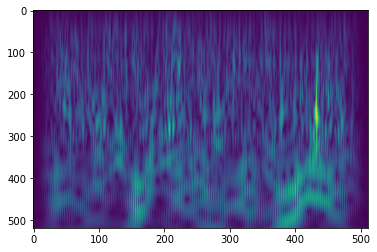

In [100]:
plt.imshow(out[0].numpy(), aspect="auto");

In [101]:
img = out.permute((1, 2, 0)).numpy()
img = (img - img.min()) / (img.max() - img.min())
img.shape

(519, 512, 3)

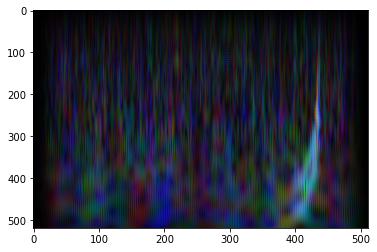

In [102]:
plt.imshow(img, aspect="auto");

In [ ]:
# spec_min, _ = torch.min(out, dim=1, keepdim=True)
# spec_min, _ = torch.min(spec_min, dim=2, keepdim=True)

# spec_max, _ = torch.max(out, dim=1, keepdim=True)
# spec_max, _ = torch.max(spec_max, dim=2, keepdim=True)

# out_norm = (out - spec_min) / (spec_max - spec_min)

def minmax_spec(features):
    spec_min, _ = torch.min(features, dim=1, keepdim=True)
    spec_min, _ = torch.min(spec_min, dim=2, keepdim=True)

    spec_max, _ = torch.max(features, dim=1, keepdim=True)
    spec_max, _ = torch.max(spec_max, dim=2, keepdim=True)

    return (features - spec_min) / (spec_max - spec_min)


out_norm = minmax_spec(out)

In [ ]:
out_norm[0].min(), out_norm[0].max()

# NumPy FFT based implementation
https://github.com/Unidata/pyCWT/blob/master/cwt.py

In [ ]:
def fft_kwargs(signal, **kwargs):
    """Return next higher power of 2 for given signal to speed up FFT"""
    return {'n': np.int(2 ** np.ceil(np.log2(len(signal))))}



class Morlet(object):
    """Implements the Morlet wavelet class.
    Note that the input parameters f and f0 are angular frequencies.
    f0 should be more than 0.8 for this function to be correct, its
    default value is f0 = 6.
    """

    def __init__(self, f0=6):
        self._set_f0(f0)
        self.name = 'Morlet'

    def psi_ft(self, f):
        """Fourier transform of the approximate Morlet wavelet."""
        return (np.pi ** -0.25) * np.exp(-0.5 * (f - self.f0) ** 2)

    def psi(self, t):
        """Morlet wavelet as described in Torrence and Compo (1998)."""
        return (np.pi ** -0.25) * np.exp(1j * self.f0 * t - t ** 2 / 2)

    def flambda(self):
        """Fourier wavelength as of Torrence and Compo (1998)."""
        return (4 * np.pi) / (self.f0 + np.sqrt(2 + self.f0 ** 2))

    def coi(self):
        """e-Folding Time as of Torrence and Compo (1998)."""
        return 1. / np.sqrt(2)

    def sup(self):
        """Wavelet support defined by the e-Folding time."""
        return 1. / self.coi

    def _set_f0(self, f0):
        # Sets the Morlet wave number, the degrees of freedom and the
        # empirically derived factors for the wavelet bases C_{\delta},
        # \gamma, \delta j_0 (Torrence and Compo, 1998, Table 2)
        self.f0 = f0             # Wave number
        self.dofmin = 2          # Minimum degrees of freedom
        if self.f0 == 6:
            self.cdelta = 0.776  # Reconstruction factor
            self.gamma = 2.32    # Decorrelation factor for time averaging
            self.deltaj0 = 0.60  # Factor for scale averaging
        else:
            self.cdelta = -1
            self.gamma = -1
            self.deltaj0 = -1

    def smooth(self, W, dt, dj, scales):
        """Smoothing function used in coherence analysis.
        Parameters
        ----------
        W :
        dt :
        dj :
        scales :
        Returns
        -------
        T :
        """
        # The smoothing is performed by using a filter given by the absolute
        # value of the wavelet function at each scale, normalized to have a
        # total weight of unity, according to suggestions by Torrence &
        # Webster (1999) and by Grinsted et al. (2004).
        m, n = W.shape

        # Filter in time.
        k = 2 * np.pi * fft.fftfreq(fft_kwargs(W[0, :])['n'])
        k2 = k ** 2
        snorm = scales / dt
        # Smoothing by Gaussian window (absolute value of wavelet function)
        # using the convolution theorem: multiplication by Gaussian curve in
        # Fourier domain for each scale, outer product of scale and frequency
        F = np.exp(-0.5 * (snorm[:, np.newaxis] ** 2) * k2)  # Outer product
        smooth = fft.ifft(F * fft.fft(W, axis=1, **fft_kwargs(W[0, :])),
                          axis=1,  # Along Fourier frequencies
                          **fft_kwargs(W[0, :], overwrite_x=True))
        T = smooth[:, :n]  # Remove possibly padded region due to FFT

        if np.isreal(W).all():
            T = T.real

        # Filter in scale. For the Morlet wavelet it's simply a boxcar with
        # 0.6 width.
        wsize = self.deltaj0 / dj * 2
        win = rect(np.int(np.round(wsize)), normalize=True)
        T = convolve2d(T, win[:, np.newaxis], 'same')  # Scales are "vertical"

        return T


In [ ]:
def _check_parameter_wavelet(wavelet):
#     mothers = {'morlet': Morlet, 'paul': Paul, 'dog': DOG,
#                'mexicanhat': MexicanHat}
    mothers = {'morlet': Morlet}
    # Checks if input parameter is a string. For backwards
    # compatibility with Python 2 we check either if instance is a
    # `basestring` or a `str`.
    try:
        if isinstance(wavelet, basestring):
            return mothers[wavelet]()
    except NameError:
        if isinstance(wavelet, str):
            return mothers[wavelet]()
    # Otherwise, return itself.
    return wavelet


def cwt(signal, dt, dj=1/12, s0=-1, J=-1, wavelet='morlet', freqs=None):
    """Continuous wavelet transform of the signal at specified scales.
    Parameters
    ----------
    signal : numpy.ndarray, list
        Input signal array.
    dt : float
        Sampling interval.
    dj : float, optional
        Spacing between discrete scales. Default value is 1/12.
        Smaller values will result in better scale resolution, but
        slower calculation and plot.
    s0 : float, optional
        Smallest scale of the wavelet. Default value is 2*dt.
    J : float, optional
        Number of scales less one. Scales range from s0 up to
        s0 * 2**(J * dj), which gives a total of (J + 1) scales.
        Default is J = (log2(N * dt / so)) / dj.
    wavelet : instance of Wavelet class, or string
        Mother wavelet class. Default is Morlet wavelet.
    freqs : numpy.ndarray, optional
        Custom frequencies to use instead of the ones corresponding
        to the scales described above. Corresponding scales are
        calculated using the wavelet Fourier wavelength.
    Returns
    -------
    W : numpy.ndarray
        Wavelet transform according to the selected mother wavelet.
        Has (J+1) x N dimensions.
    sj : numpy.ndarray
        Vector of scale indices given by sj = s0 * 2**(j * dj),
        j={0, 1, ..., J}.
    freqs : array like
        Vector of Fourier frequencies (in 1 / time units) that
        corresponds to the wavelet scales.
    coi : numpy.ndarray
        Returns the cone of influence, which is a vector of N
        points containing the maximum Fourier period of useful
        information at that particular time. Periods greater than
        those are subject to edge effects.
    fft : numpy.ndarray
        Normalized fast Fourier transform of the input signal.
    fftfreqs : numpy.ndarray
        Fourier frequencies (in 1/time units) for the calculated
        FFT spectrum.
    Example
    -------
    >> mother = wavelet.Morlet(6.)
    >> wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(signal,
           0.25, 0.25, 0.5, 28, mother)
    """
    wavelet = _check_parameter_wavelet(wavelet)

    # Original signal length
    n0 = len(signal)
    # If no custom frequencies are set, then set default frequencies
    # according to input parameters `dj`, `s0` and `J`. Otherwise, set wavelet
    # scales according to Fourier equivalent frequencies.
    if freqs is None:
        # Smallest resolvable scale
        if s0 == -1:
            s0 = 2 * dt / wavelet.flambda()
        # Number of scales
        if J == -1:
            J = np.int(np.round(np.log2(n0 * dt / s0) / dj))
        # The scales as of Mallat 1999
        sj = s0 * 2 ** (np.arange(0, J + 1) * dj)
        # Fourier equivalent frequencies
        freqs = 1 / (wavelet.flambda() * sj)
    else:
        # The wavelet scales using custom frequencies.
        sj = 1 / (wavelet.flambda() * freqs)

    # Signal Fourier transform
    signal_ft = fft.fft(signal, **fft_kwargs(signal))
    N = len(signal_ft)
    # Fourier angular frequencies
    ftfreqs = 2 * np.pi * fft.fftfreq(N, dt)

    # Creates wavelet transform matrix as outer product of scaled transformed
    # wavelets and transformed signal according to the convolution theorem.
    # (i)   Transform scales to column vector for outer product;
    # (ii)  Calculate 2D matrix [s, f] for each scale s and Fourier angular
    #       frequency f;
    # (iii) Calculate wavelet transform;
    sj_col = sj[:, np.newaxis]
    psi_ft_bar = ((sj_col * ftfreqs[1] * N) ** .5 *
                  np.conjugate(wavelet.psi_ft(sj_col * ftfreqs)))
    W = fft.ifft(signal_ft * psi_ft_bar, axis=1,
                 **fft_kwargs(signal_ft, overwrite_x=True))

    # Checks for NaN in transform results and removes them from the scales if
    # needed, frequencies and wavelet transform. Trims wavelet transform at
    # length `n0`.
    sel = np.invert(np.isnan(W).all(axis=1))
    if np.any(sel):
        sj = sj[sel]
        freqs = freqs[sel]
        W = W[sel, :]

    # Determines the cone-of-influence. Note that it is returned as a function
    # of time in Fourier periods. Uses triangualr Bartlett window with
    # non-zero end-points.
    coi = (n0 / 2 - np.abs(np.arange(0, n0) - (n0 - 1) / 2))
    coi = wavelet.flambda() * wavelet.coi() * dt * coi

    return (W[:, :n0], sj, freqs, coi, signal_ft[1:N//2] / N ** 0.5,
            ftfreqs[1:N//2] / (2 * np.pi))

In [ ]:
wave, scales, freqs, coi, fft, fftfreqs = cwt(x[0], 1/2048, dj=0.0625)
wave.shape

In [ ]:
plt.imshow(np.absolute(wave[18:92]), aspect="auto");

# FFT based implementaion

From https://www.kaggle.com/mistag/wavelet1d-custom-keras-wavelet-transform-layer

In [ ]:
nv = 12  # Number of voices
f_low = 20
f_high = 1000
sr = 2048

max_scale = 4096 // (np.sqrt(2) * 2)
max_scale = np.floor(nv * np.log2(max_scale))
scales = 2 * (2 ** (1 / nv)) ** np.arange(0, max_scale + 1)
frequencies = sr * (6 / (2 * np.pi)) / scales
frequencies = frequencies[frequencies >= f_low]  # remove low frequencies
scales = scales[0 : len(frequencies)]
frequencies = frequencies[frequencies <= f_high]  # remove high frequencies
scales = scales[len(scales) - len(frequencies) : len(scales)]

num_scales = scales.shape[-1]

scales

In [ ]:
padvalue = 4096 // 2
n = padvalue * 2 + 4096
omega = np.arange(1, math.floor(n / 2) + 1, dtype=np.float64)
omega = omega * (2 * np.pi) / n
omega = np.concatenate(
    (
        np.array([0]),
        omega,
        -omega[np.arange(math.floor((n - 1) / 2), 0, -1, dtype=int) - 1],
    )
)
_wft = np.zeros([scales.size, omega.size])

for jj, scale in enumerate(scales):
    expnt = -((scale * omega - 6) ** 2) / 2 * (omega > 0)
    _wft[jj,] = (
        2 * np.exp(expnt) * (omega > 0)
    )